In [6]:
import torch
import os
import h5py
import pandas as pd
import numpy as np
import shutil
from sklearn.model_selection import train_test_split
from utils.PathDataset import Pathology_Dataset_test
from torch.utils.data import Dataset, DataLoader
from lifelines.utils import concordance_index
from models.MLP import MLP
from utils.img_processing import convert_path,name_pinyin,convert_path
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [7]:
df_train_MR = pd.read_csv(convert_path('G:\glioma\\final_data\glioma_survive\only_mr\\result\\train_TCGA.csv'))
df_test_MR = pd.read_csv(convert_path('G:\glioma\\final_data\glioma_survive\only_mr\\result\\test_TCGA.csv'))
df_ex_test_MR = pd.read_csv(convert_path('G:\glioma\\final_data\glioma_survive\only_mr\\result\\ex_huashan.csv'))

df_train_path = pd.read_csv(convert_path('G:\glioma\\final_data\glioma_survive\only_path\\result\\train_TCGA.csv'))
df_train_path.rename(columns={'score':'score_path'},inplace=True)
df_train_path = pd.DataFrame(df_train_path[['patient','score_path']])
df_test_path = pd.read_csv(convert_path('G:\glioma\\final_data\glioma_survive\only_path\\result\\test_TCGA.csv'))
df_test_path.rename(columns={'score':'score_path'},inplace=True)
df_test_path = pd.DataFrame(df_test_path[['patient','score_path']])
df_ex_test_path = pd.read_csv(convert_path('G:\glioma\\final_data\glioma_survive\only_path\\result\\ex_huashan.csv'))
df_ex_test_path.rename(columns={'score':'score_path'},inplace=True)
df_ex_test_path = pd.DataFrame(df_ex_test_path[['patient','score_path']])

df_train = pd.merge(df_train_MR,df_train_path,how='inner')
df_test = pd.merge(df_test_MR,df_test_path,how='inner')
df_ex_test = pd.merge(df_ex_test_MR,df_ex_test_path,how='inner')



In [11]:
df_train.to_csv(convert_path('G:\glioma\\final_data\glioma_survive\mr_pathology_post\\result\\train_TCGA.csv'),index=False)
df_test.to_csv(convert_path('G:\glioma\\final_data\glioma_survive\mr_pathology_post\\result\\test_TCGA.csv'),index=False)
df_ex_test.to_csv(convert_path('G:\glioma\\final_data\glioma_survive\mr_pathology_post\\result\\ex_huashan.csv'),index=False)

In [3]:
from sksurv.util import Surv
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
)
y_train_ = Surv.from_dataframe(
    event='status_dead', 
    time='survival_month', 
    data=df_train)
y_test_ = Surv.from_dataframe(
    event='status_dead', 
    time='survival_month', 
    data=df_test)
y_ex_test_ = Surv.from_dataframe(
    event='status_dead', 
    time='survival_month', 
    data=df_ex_test)
hazard_label = ['score','score_path','WHO','Age','Gender','IDH']
train_feature = df_train[hazard_label].values
test_feature = df_test[hazard_label].values
ex_test_feature = df_ex_test[hazard_label].values
# cox 模型
cph = CoxPHSurvivalAnalysis()
cph.fit(train_feature, y_train_)
cph_score = cph.score(test_feature,y_test_)
print("cph C-index: ", cph_score)
cph_score_ex = cph.score(ex_test_feature,y_ex_test_)
print("ex cph C-index: ", cph_score_ex)

cph C-index:  0.8989071038251366
ex cph C-index:  0.7741935483870968


Text(0.5, 1.0, 'Time ROC in Feature Extractor Base Post Fusion with MR and Pathology')

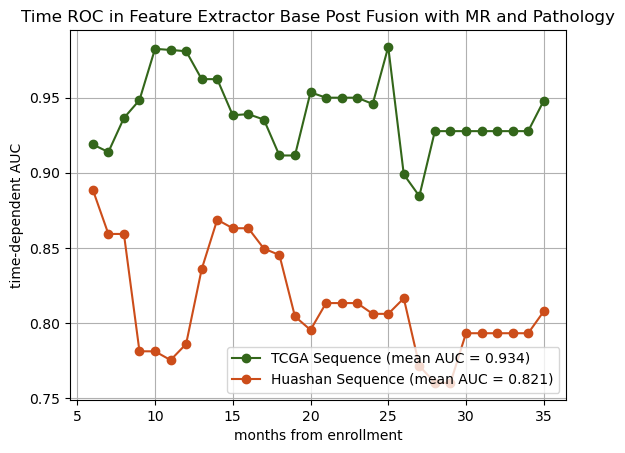

: 

In [4]:
va_times = np.arange(6, 36, 1)
cph_risk_scores = cph.predict(test_feature)
cph_auc, cph_mean_auc = cumulative_dynamic_auc(y_train_, y_test_, cph_risk_scores, va_times)

cph_risk_scores_ex = cph.predict(ex_test_feature)
cph_auc_ex, cph_mean_auc_ex = cumulative_dynamic_auc(y_train_, y_ex_test_, cph_risk_scores_ex, va_times)




plt.plot(va_times, cph_auc,color=(0.2, 0.4, 0.1) ,marker="o",label=f"TCGA Sequence (mean AUC = {cph_mean_auc:.3f})")
plt.plot(va_times, cph_auc_ex,color=(0.8, 0.3, 0.1) ,marker="o",label=f"Huashan Sequence (mean AUC = {cph_mean_auc_ex:.3f})")
# plt.axhline(cph_mean_auc, linestyle="--",color=(0.8, 0.3, 0.1))

plt.xlabel("months from enrollment")
plt.ylabel("time-dependent AUC")
plt.legend(loc="lower right")
plt.grid(True)
plt.title('Time ROC in Feature Extractor Base Post Fusion with MR and Pathology')